In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal, Optional
from sklearn.manifold import TSNE
from umap import UMAP
import itertools
from pathlib import Path
from loguru import logger
from matplotlib.axes import Axes
from tqdm import tqdm
import pandas as pd

from histaug.utils import load_features
from histaug.metrics import SIMILARITY_METRICS, ensure_tensor

figures_dir = Path("/app/figures/macenko/kather100k")
figures_dir.mkdir(exist_ok=True, parents=True)

N = 10000

feature_extractor_groups = [
    ["swin", "ctranspath"],
    ["vit", "owkin"],
    ["resnet50", "retccl", "bt", "swav"],
    ["dino_p16"],
]
feature_extractor_to_groupid = {
    feature_extractor: groupid
    for groupid, feature_extractors in enumerate(feature_extractor_groups)
    for feature_extractor in feature_extractors
}
group_names = ["Swin", "ViT-B", "ResNet-50", "ViT-S"]
feature_extractors = list(itertools.chain.from_iterable(feature_extractor_groups))
metric = "cosine"
aug = "Macenko"

In [2]:
features_by_model = {
    model: load_features(
        f"/data/histaug/features/kather100k/{model}.zarr",
        remove_classes=["BACK"],
        augmentations=(aug,),
        n=N,
    )
    for model in tqdm(feature_extractors)
}

100%|██████████| 9/9 [00:43<00:00,  4.79s/it]


In [3]:
classes = sorted(np.unique(next(iter(features_by_model.values())).labels))
classes

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

In [4]:
def compute_dists(a: np.ndarray, b: np.ndarray):
    a = ensure_tensor(a)
    b = ensure_tensor(b)
    dists = SIMILARITY_METRICS[metric](a, b)
    return dists.numpy()


def compute_interclass_dists(features, n=10000):
    a = np.random.randint(0, len(features.feats), n)
    b = np.random.randint(0, len(features.feats), n)
    while (mask := ((a == b) | (features.labels[a] == features.labels[b]))).any():
        # Resample
        b[mask] = np.random.randint(0, len(features.feats), mask.sum())
    return compute_dists(features.feats[a], features.feats[b])


def compute_intraclass_dists(features, n=10000):
    a = np.random.randint(0, len(features.feats), n)
    b = np.random.randint(0, len(features.feats), n)
    while (mask := ((a == b) | (features.labels[a] != features.labels[b]))).any():
        # Resample
        b[mask] = np.random.randint(0, len(features.feats), mask.sum())
    return compute_dists(features.feats[a], features.feats[b])


def compute_feature_dists(features, n=10000):
    a = np.random.randint(0, len(features.feats), n)
    b = np.random.randint(0, len(features.feats), n)
    while (mask := ((a == b))).any():
        # Resample
        b[mask] = np.random.randint(0, len(features.feats), mask.sum())
    return compute_dists(features.feats[a], features.feats[b])

In [5]:
df = pd.DataFrame(
    [
        {
            "model": model,
            f"dist_{aug}": (d_aug := compute_dists(features.feats, features.feats_augs[aug])).mean(),
            f"dist_{aug}_std": d_aug.std(),
            "dist_feature": (d_feature := compute_feature_dists(features)).mean(),
            "dist_feature_std": d_feature.std(),
            "dist_intra": (d_intra := compute_intraclass_dists(features)).mean(),
            "dist_intra_std": d_intra.std(),
            "dist_inter": (d_inter := compute_interclass_dists(features)).mean(),
            "dist_inter_std": d_inter.std(),
        }
        for model, features in tqdm(features_by_model.items())
    ]
).set_index("model")

100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


<Axes: xlabel='model'>

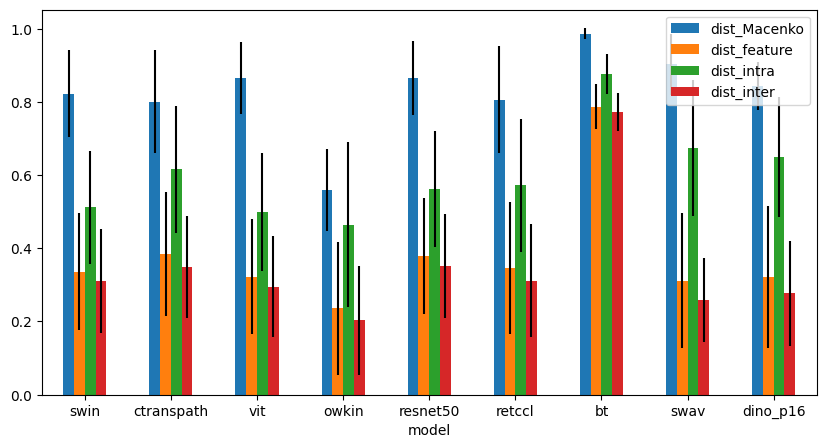

In [6]:
df_std = df.filter(regex="std")
df_mean = df.drop(columns=df_std.columns)
df_std.columns = df_std.columns.str.replace("_std", "")
df_mean.plot.bar(yerr=df_std, rot=0, figsize=(10, 5))

<Axes: xlabel='model'>

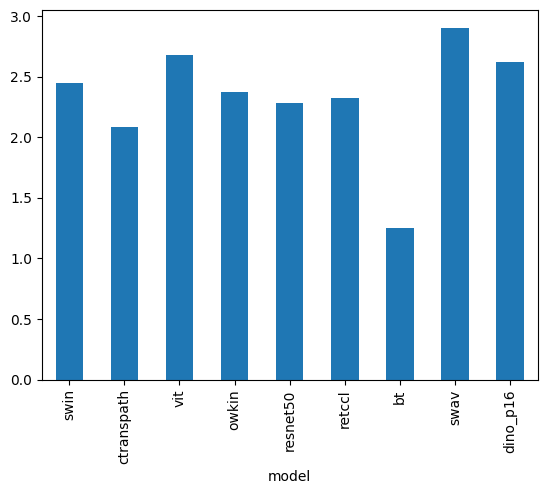

In [147]:
(df.dist_Macenko / df.dist_feature).plot.bar()

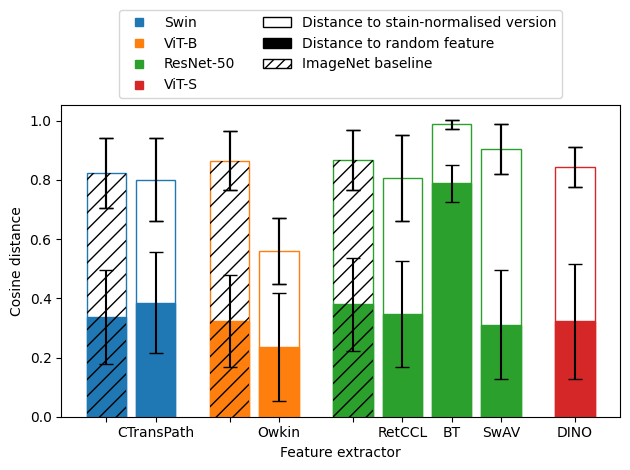

In [159]:
import matplotlib

cmap = plt.get_cmap("tab10")


xs = np.cumsum([1 if i != 0 else 1.5 for group in feature_extractor_groups for i, _ in enumerate(group)])
xs = xs - xs[0]

plt.bar(
    xs,
    df[f"dist_{aug}"],
    yerr=df[f"dist_{aug}_std"],
    label="Distance to stain-normalized version",
    edgecolor=[cmap(feature_extractor_to_groupid[x]) for x in df.index],
    color="none",
    capsize=5,
)
plt.bar(
    xs,
    df.dist_feature,
    yerr=df.dist_feature_std,
    label="Distance to random feature",
    edgecolor=[cmap(feature_extractor_to_groupid[x]) for x in df.index],
    color=[cmap(feature_extractor_to_groupid[x]) for x in df.index],
    capsize=5,
)
plt.bar(
    xs,
    df[f"dist_{aug}"],
    yerr=df[f"dist_{aug}_std"],
    label="Distance to stain-normalized version",
    edgecolor="black",
    hatch=["//" if x in ["swin", "vit", "resnet50"] else "" for x in df.index],
    color="none",
    capsize=5,
    lw=0.0,
)
plt.ylabel("Cosine distance")
plt.xlabel("Feature extractor")
plt.xticks(
    xs,
    df.index.map(
        {
            "swin": "",
            "ctranspath": "CTransPath",
            "vit": "",
            "owkin": "Owkin",
            "resnet50": "",
            "retccl": "RetCCL",
            "bt": "BT",
            "swav": "SwAV",
            "dino_p16": "DINO",
        }
    ),
)
plt.yticks(np.arange(0, 1.1, 0.2))

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

handles = [
    *[
        # Dot to represent feature extractor
        Line2D(
            [0], [0], marker="s", color="none", markerfacecolor=cmap(groupid), markeredgecolor=cmap(groupid), label=name
        )
        for groupid, name in enumerate(group_names)
    ],
    Patch(facecolor="none", edgecolor="black", label="Distance to stain-normalised version"),
    Patch(facecolor="black", edgecolor="black", label="Distance to random feature"),
    Patch(facecolor="none", edgecolor="black", hatch="///", label="ImageNet baseline")
    # Line2D([0], [0], marker="o", color="none", markerfacecolor="black", label="Ratio (stain-normalised vs. random)"),
]
# plt.legend(handles=handles, ncols=2, loc="upper center", bbox_to_anchor=(0.5, -0.15))
plt.legend(handles=handles, ncols=2, loc="lower center", bbox_to_anchor=(0.5, 1.0))

plt.tight_layout()